# R-SHAP Implementation

### Workspace Prep

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger

import tensorboard

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import tqdm as notebook_tqdm



# caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')
# sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\lstm')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\utils')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\lstm')

import preprocessing as pp
from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

from lstm_model import BasicLSTM


Uncomment below to install missing modules

In [2]:
# !pip install ipywidgets

In [3]:
# pip install tensorboard

In [4]:
# pip install --ignore-installed PyYAML  # might be necessary to run before installing pytorch

In [5]:
# pip install pytorch-lightning

In [6]:
# pip install torch

### Load and Pre-processs Stock Data

In [7]:
df_sb = pd.read_csv('SBUX.csv', index_col='Date', parse_dates=True)

In [8]:
display(df_sb)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,81.116577,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,82.634186,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,83.065117,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,83.168152,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,82.559242,7296900
...,...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,97.790939,6952700
2020-12-07,102.010002,102.220001,100.690002,101.410004,96.959137,4514800
2020-12-08,100.370003,101.570000,100.010002,101.209999,96.767899,3911300


<AxesSubplot: title={'center': 'Starbucks Sales Volume'}, xlabel='Date'>

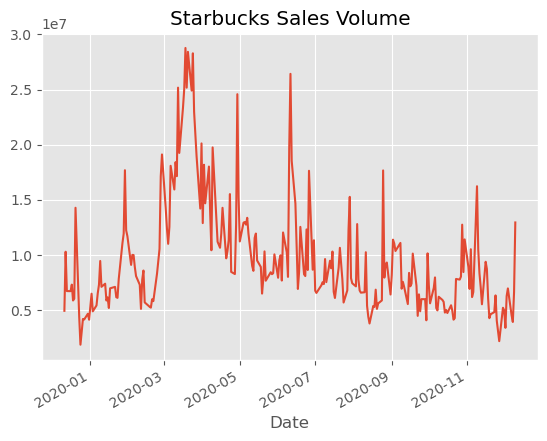

In [9]:
df_sb['Volume'].plot(title='Starbucks Sales Volume')

In [10]:
def processdata(df, day_feat, day_targ):
    df_scaled = pp.std_values(df, 'minmax')

    X_train, X_test, T_train, T_test = pp.split_data_validate(df_scaled, 'Volume')

    dl_train, ds_train = pp.lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, None )
    dl_test, ds_test = pp.lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, None)

    return dl_train, ds_train, dl_test, ds_test

def train_model(model, data, epochs, logger_name):
    logger = TensorBoardLogger("lightning_logs", name=logger_name)
    trainer = pl.Trainer(max_epochs=epochs,logger=logger)

    trainer.fit(model, train_dataloaders=data)
    trainer.test(model,dataloaders=dl_test)

dl_train, ds_train, dl_test, ds_test = processdata(df_sb, 3, 0)



## Test Our LSTM Model On Starbucks Data

In [11]:
our_model = BasicLSTM(num_feat=5, num_hiddens=1, num_out=1, lr=0.01)

train_model(our_model, dl_train, 3, 'our_model')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
30        Trainable params
0         Non-trainable params
30        Total params
0.000     Total estimated model params size (MB)
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.010755012399474774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Build Pytorch LSTM Model

In [12]:
class LSTMval(pl.LightningModule):
    def __init__(self, num_feat, num_hiddens, num_layers, lr):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = num_feat #input size
        self.hidden_size = num_hiddens #hidden state
        # self.seq_length = seq_length #sequence length
        self.lr = lr
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True) #lstm
    
    def forward(self,x):
        # h_0 = Variable(torch.zeros(self.num_layers, self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, self.hidden_size)) #internal state
        # print(h_0,c_0)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        return output
    

    def configure_optimizers(self):
        return Adam(self.parameters(), lr = self.lr)
    
    def training_step(self,batch,batch_idx):
        input_i, label_i = batch
        # print(input_i[0],torch.transpose(input_i[0],0,1))
        output_i = self.forward(torch.transpose(input_i[0],0,1))[0]
        
        loss = (output_i - label_i)**2
        
        self.log("training loss", loss, logger=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(torch.transpose(input_i[0],0,1))[0]
        
        test_loss = (output_i - label_i)**2
        
        self.log("test_loss", test_loss, on_step=True, logger=True)


### Test Pytorch LSTM Model on Starbucks Data

In [13]:
val_mdl = LSTMval(num_feat = 5, num_hiddens = 1, num_layers = 1, lr = 0.01).double()

In [14]:
logger = TensorBoardLogger("lightning_logs", name="SBUX")
trainer = pl.Trainer(max_epochs=3,logger=logger)
trainer.fit(val_mdl, train_dataloaders =dl_train)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 32    
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [15]:
trainer.test(val_mdl,dataloaders = dl_test)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.011306646708572878
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.011306646708572878}]